In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import pytorch_lightning as pl

import utils

%load_ext autoreload
%autoreload 1
%aimport utils

In [2]:
data_folder = '../data/'

In [3]:
df = utils.read_preprocessed_financial_data(data_folder)
df.shape 

(3751083, 10)

In [4]:
df.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description,week
0,39026145.0,0,4814.0,1030,-2245.92,311690,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ,0
1,39026145.0,13328582400,4814.0,1030,-5614.79,311690,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ,0
2,39026145.0,17673984000,4814.0,1030,-1122.96,311690,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ,1
3,39026145.0,30168547200,4814.0,1030,-2245.92,311690,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ,1
4,39026145.0,48592051200,4814.0,1030,-2245.92,311690,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ,1


In [5]:
clients = df['customer_id'].unique()
clients = clients[:100] # drop this row (I just tested the code with small amount of data)

df_week = []

for client_id in tqdm(clients):
    client_data = df[df['customer_id'] == client_id]
    client_weeks = client_data.week.unique()
    
    for week in client_weeks:
        client_data_week = client_data[client_data['week'] == week]
        df_week.append(
            {
                'transactions': client_data_week['mcc_code'].tolist(),
                'amounts': client_data_week['amount'].tolist(),
                'tr_datetime': client_data_week['tr_datetime'].tolist(),
                'tr_type': client_data_week['tr_type'].tolist(),
                'mcc_description': client_data_week['mcc_description'].tolist(), # add mcc_description embeddings
                'tr_description': client_data_week['tr_description'].tolist(), # add tr_description embeddings
                'term_id': client_data_week['term_id'].tolist(),
                'customer_id': client_id, 
                'week': week,
                'gender': client_data_week['gender'].tolist()
            }
        )

100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


In [6]:
df_week = pd.DataFrame(df_week)
df_week.shape

(5990, 10)

In [7]:
df_week.head()

,transactions,amounts,tr_datetime,tr_type,mcc_description,tr_description,term_id,customer_id,week,gender
0,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-2245.92, -5614.79, -1392.47, -920.83, -1010....","[0, 13328582400, 3317241600, 9680601600, 14449...","[1030, 1030, 1010, 1010, 1010, 1010, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[4814.0, 4814.0, 4814.0, 4814.0, 4814.0, 5499....","[-1122.96, -2245.92, -2245.92, -2245.92, -2245...","[17673984000, 30168547200, 48592051200, 487840...","[1030, 1030, 1030, 1030, 1030, 1010, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[4814.0, 4814.0, 4814.0, 5331.0, 5331.0, 5331....","[-2245.92, -449.18, -1122.96, -6288.56, -1122....","[42837984000, 79248240000, 79340169600, 0, 0, ...","[1030, 1030, 1030, 1110, 1110, 1110, 1110, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5331....","[-2245.92, -1122.96, -2919.69, -4491.83, -1010...","[39586060800, 91743062400, 0, 0, 0, 0, 0, 0, 1...","[1030, 1030, 1110, 1110, 1110, 1110, 1110, 111...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-1122.96, -2245.92, -1617.06, -4238.04, -1909...","[103724323200, 103797936000, 59906649600, 1619...","[1030, 1030, 1010, 1010, 1010, 1010, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [8]:
MIN_LEN = 20
MAX_LEN = 50

lens = df_week.transactions.apply(lambda x: len(x))
df_week = df_week[(lens >= MIN_LEN) & (lens <= MAX_LEN)]
df_week

,transactions,amounts,tr_datetime,tr_type,mcc_description,tr_description,term_id,customer_id,week,gender
13,"[4814.0, 4814.0, 4814.0, 4814.0, 5499.0, 5499....","[-3368.87, -2245.92, -6737.75, -3368.87, -606....","[396630432000, 199102924800, 570217190400, 574...","[1030, 1030, 1030, 1030, 1110, 1110, 1110, 111...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,14,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
17,"[4814.0, 4814.0, 5411.0, 5499.0, 5499.0, 5499....","[-2245.92, -2245.92, -3818.06, -2358.21, -772....","[658533888000, 158304326400, 0, 412139404800, ...","[1030, 1030, 1110, 1010, 1010, 1010, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,19,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
23,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-4491.83, -2245.92, -3256.58, -4042.65, -5794...","[641373120000, 679394304000, 0, 0, 0, 42582697...","[1030, 1030, 1110, 1110, 1110, 1010, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,27,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
26,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-2245.92, -2245.92, -5277.9, -14014.51, -2695...","[451967040000, 1147778899200, 0, 0, 0, 0, 0, 0...","[1030, 1030, 1110, 1110, 1110, 1110, 1110, 111...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[280794, 280793, 298322, 298323, 298323, 29832...",39026145.0,30,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
28,"[4814.0, 4814.0, 5499.0, 5499.0, 5331.0, 5331....","[-1122.96, -3368.87, -5985.37, -10623.18, -898...","[663038438400, 610950988800, 0, 0, 0, 0, 10153...","[1030, 1030, 1110, 1110, 1110, 1110, 1010, 101...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[282665, 282665, 298323, 298322, 298325, 29832...",39026145.0,32,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...
5724,"[5411.0, 5411.0, 5411.0, 5411.0, 5411.0, 5411....","[-4697.11, -4208.85, -4208.85, -2872.53, -4208...","[1766503468800, 1456256534400, 1497560140800, ...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[Бакалейные магазины, супермаркеты, Бакалейные...","[Покупка. POS ТУ СБ РФ, Покупка. POS ТУ СБ РФ,...","[285853, 285853, 285854, 285854, 285853, 28585...",62605812.0,63,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5725,"[5411.0, 5411.0, 5411.0, 5411.0, 5411.0, 5411....","[-5491.26, -3366.63, -3366.63, -3366.63, -4936...","[1652565196800, 2570434560000, 1638264355200, ...","[1010, 1010, 1010, 1010, 1010, 1010, 1010, 101...","[Бакалейные магазины, супермаркеты, Бакалейные...","[Покупка. POS ТУ СБ РФ, Покупка. POS ТУ СБ РФ,...","[285854, 285854, 285854, 285854, 285853, 28585...",62605812.0,64,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5752,"[4814.0, 4814.0, 4814.0, 4814.0, 4814.0, 4814....","[-3368.87, -3368.87, -2245.92, -3368.87, -2245...","[31209494400, 27294796800, 52831180800, 640789...","[1030, 1030, 1030, 1030, 1030, 1030, 1030, 103...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",12678722.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5753,"[4814.0, 4814.0, 4814.0, 5499.0, 5735.0, 6011....","[-4491.83, -2245.92, -6737.75, -12352.54, -148...","[44605209600, 100389715200, 33127488000, 49390...","[1030, 1030, 1030, 1010, 1200, 7010, 7010, 701...","[Звонки с использованием телефонов, считывающи...","[Оплата услуги. Банкоматы СБ РФ, Оплата услуги...","[311690, 311690, 311690, 311690, 311690, 31169...",12678722.0,2,

In [12]:
features = ['transactions', 'amounts'] # add mcc_description and tr_description 

INPUT_SIZE = len(features)
EPOCHS = 10

In [13]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 977   
1 | loss_function | BCELoss | 0     
------------------------------------------
977       Trainable params
0         Non-trainable params
977       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

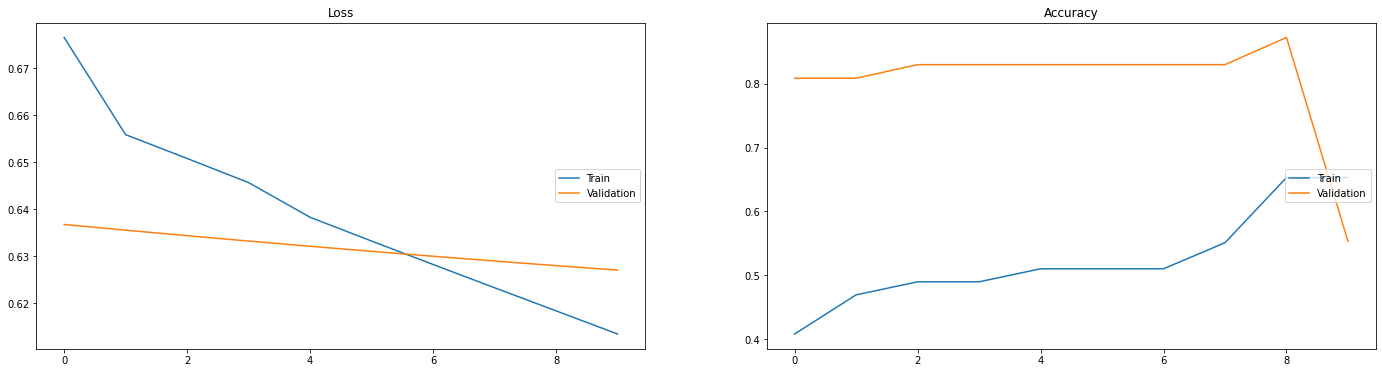

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 977   
1 | loss_function | BCELoss | 0     
------------------------------------------
977       Trainable params
0         Non-trainable params
977       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
group_kfold = GroupKFold(n_splits=5)
metrics = {'Accuracy': [], 'ROC AUC': [], 'PR AUC': []}
for train_index, test_index in group_kfold.split(X=df_week, groups=df_week['customer_id']):
    train_data = df_week.iloc[train_index]
    test_data = df_week.iloc[test_index]
    
    random.seed(123)
    val_customer_id = random.sample(train_data['customer_id'].unique().tolist(), int(train_data['customer_id'].nunique() * 0.3))
    val_data = train_data[train_data['customer_id'].isin(val_customer_id)]
    train_data = train_data[~train_data['customer_id'].isin(val_customer_id)]
    
    train_dataset = utils.create_dataset(train_data, features, batch_size=64, shuffle=True)
    val_dataset = utils.create_dataset(val_data, features, batch_size=64, shuffle=False)
    test_dataset = utils.create_dataset(test_data, features, batch_size=64, shuffle=False)
    
    model = utils.ClassificationModel(
        model=base_model,
        train_data=train_dataset,
        test_data=val_dataset
    )
    experiment_name = 'gru'

    logger = pl.loggers.TensorBoardLogger(save_dir='../logs/', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'../logs/{experiment_name}',
        filename='{epoch:02d}-{val_loss:.3f}',
        mode='min')

    trainer = pl.Trainer(
        max_epochs=EPOCHS, 
        gpus=[1],  
        benchmark=True, 
        check_val_every_n_epoch=1, 
        logger=logger,
        callbacks=[checkpoint_callback])

    trainer.fit(model)

    dict_logs = utils.plot_train_process(logger.log_dir)
    plt.show()
    
    test_predictions, test_targets, metric = utils.test_model(model, test_dataset)
    metrics['Accuracy'].append(metric[0])
    metrics['ROC AUC'].append(metric[1])
    metrics['PR AUC'].append(metric[2])

In [ ]:
metrics

In [ ]:
for metric_name, metric_val in metrics.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))